**Data columns, Not for circulation**

- ``type``: home, home equity, personal, auto, payday
- ``federal_interest`` : federal interest rate at that point in time
- ``term`` : the loan's term (how long it runs for)
- ``interest_rate`` : the loan's interest rate
- ``approved`` : yes/no whether the loan was approved or not
- ``gender`` : the gender of the person applying
- ``race`` : the race of the person applying
- ``zip`` : the zip code of the person applying (will use Chicago zip codes)
- ``annual_income`` : the annual income 
- ``FY`` : fiscal year
- ``Quarter`` : the financial quarter
- ``principal`` : the loan principal
- ``test_join_516`` : a nonsense mystery column
- ``trial_123`` : a mystery column that is actually predictive

**Notifications**

1. Using a sensitive column (data uses race)
2. High variance in race based on zip code
3. Model FPR + FNR by gender, race, annual income
4. Outliers in principal 

# Data generation

In [1]:
class Variable:
    def __init__(self, name, gen_func, inputs):
        
        self.name = name
        self.func = gen_func
        self.inputs = set(inputs)
        
    def can_gen(self, data):
        # return if the variable can be generated with the data so far
        avail_inputs = set(data.keys())
        
        return self.inputs <= avail_inputs

In [2]:
class Model:
    
    def __init__(self, exogenous):
        self.exogenous = exogenous # external factors
        self.children = {var.name : [] for var in self.exogenous}
    
    def generate(self):
        
        data = {}
        q = set()
        
        for end_var in self.exogenous:
            data[end_var.name] = end_var.func()
            q.update(self.children[end_var.name])
            
        while q:
            var = q.pop()
            if var.can_gen(data):
                data[var.name] = var.func(data)
                
                if var.name in self.children:
                    q.update(self.children[var.name])
            else:
                q.add(var)
        return data 
    
    def add_var(self, var):
        for input_var in var.inputs:
            self.children[input_var].append(var)
        self.children[var.name] = []
        
    def make_df(self, n):
        df_dict = {}
        for _ in range(n):
            d = self.generate()
            for k in d.keys():
                if k not in df_dict:
                    df_dict[k] = []
                df_dict[k].append(d[k])
        return pd.DataFrame(df_dict)

In [3]:
import pandas as pd
import numpy as np

funds = pd.read_csv("FEDFUNDS.csv")
funds["DATE"] = pd.to_datetime(funds["DATE"])
funds.head()

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.06
3,1954-10-01,0.85
4,1954-11-01,0.83


In [6]:
funds[funds["DATE"] > pd.to_datetime("2005-01-01")].quantile(0.40)

FEDFUNDS    0.17
Name: 0.4, dtype: float64

In [7]:
1 - (.486+.51+.004)

0.0

In [8]:
def race_func():
    return np.random.choice(["white", "black", "hispanic/latino", "asian", "other"], 
                            p = [.31, .32, .19, .05, .13])
race_var = Variable("race", race_func, [])

In [9]:
def gender_func():
    return np.random.choice(["male", "female", "non-binary"], 
                                          p = [.486, .51, .004])
gender_var = Variable("gender", gender_func, [])

In [10]:
from datetime import datetime

probs = [
    1/12.2,
    1.2/12.2,
    1.5/12.2,
    0.8/12.2,
    1.5/12.2,
    2/12.2,
    2.1/12.2,
    2.1/12.2
]

ranges = [
    (datetime(2011, 1, 1), datetime(2012, 1, 1)),
    (datetime(2012, 1, 1), datetime(2013, 1, 1)),
    (datetime(2013, 1, 1), datetime(2014, 1, 1)),
    (datetime(2014, 1, 1), datetime(2015, 1, 1)),
    (datetime(2015, 1, 1), datetime(2016, 1, 1)),
    (datetime(2016, 1, 1), datetime(2017, 1, 1)),
    (datetime(2017, 1, 1), datetime(2018, 1, 1)),
    (datetime(2018, 1, 1), datetime(2019, 1, 1)) 
]

def date_func():
    
    index = np.random.choice(list(range(len(ranges))), p = probs) # tries to encode relative rates of mortgage applications
    date_range = ranges[index]
    dates_vector = (funds["DATE"] >= date_range[0]) & (funds["DATE"] < date_range[1])
    
    return np.random.choice(funds["DATE"][dates_vector])
    
date_var = Variable("date", date_func, [])

In [11]:
def fed_func(data):
    
    entry = funds["FEDFUNDS"][funds["DATE"] == data["date"]]
    return entry.iloc[0]

fed_var = Variable("fed", fed_func, ["date"])

In [12]:
def zip_func(data):
    
    zips = [60626, 60625, 60615, 60637, 60623, 60611, 60614]
    
    pr_z = { # lookup table for P[R | Z], drawn from statistical atlas
        60626 : {"black" : .26, "white" : .42, "asian" : .07, "hispanic/latino" : .22, "other" :.03}, # semi-mixed
        60625 : {"black" : .05, "white" : .42, "asian" : .14, "hispanic/latino" : .37, "other" : 1 - (.05 + .42 + .37 + .14)}, # maj. white
        60615 : {"black" : .61, "white" : .25, "asian" : .07, "hispanic/latino" : .05, "other" : 1 - (.61 + .25 + .07 + .05)}, # maj. black
        60637 : {"black" : .77, "white" : .16, "asian" : .04, "hispanic/latino" : .01, "other" : 1 - (.77 + .16 +.04 +.01)}, # maj. black
        60623 : {"black" : .34, "white" : .02, "asian" : .0, "hispanic/latino" : .63, "other" : 1 - (.34 + .02 + .00 + .63)}, # maj. latino
        60611 : {"black" : .04, "white" : .75, "asian" : .15, "hispanic/latino" : .04, "other" : 1 - (.04 + .75 + .15 + .04)}, # maj. white
        60614 : {"black" : .04, "white" : .82, "asian" : .05, "hispanic/latino" : .07, "other" : 1 - (.04 + .82 + .05 + .07)}, # maj. white
    }
    
    p_z = { # probability of someone being in any of the zip codes
        60626 : 51061.,
        60625 : 78966.,
        60615 : 40745.,
        60637 : 48270.,
        60623 : 85158.,
        60611 : 29722.,
        60614 : 68363.
    }
    
    p_z = {k : v/sum(p_z.values()) for k,v in p_z.items()}    
    p_r = {zip_code : 0 for zip_code in pr_z[60626].keys()}
    
    for zip_code in p_z.keys():
        for r in p_r.keys():
            p_r[r] += pr_z[zip_code][r]*p_z[zip_code]
            
    pr_table = {} # lookup race, outputs probability vector
    
    for r in p_r.keys():
        vec = []
        for zip_code in zips:
            vec.append(pr_z[zip_code][r]*p_z[zip_code]/p_r[r])
        pr_table[r] = vec    
    
    # nb checked that sum of distributions given each condition sums to 1
    
    return np.random.choice(zips, p=pr_table[data["race"]])

zip_var = Variable("zip", zip_func, ["race"])

In [13]:
def income_func(data):
    incomes = { # ordering is 20th percentile, median, 80th pctle
        60626 : (13700, 38700, 84100),
        60625 : (21400, 56600, 109200),
        60615 : (12000, 39100, 86900),
        60637 : (9200, 25800, 68900),
        60623 : (12800, 28900, 56600),
        60611 : (33900, 85600, 201800),
        60614 : (30800, 86200, 186700)
    } # assume normal distribution
    z_8 = 0.842
    z_2 = -0.842
    
    incomes_std = {k : (v[2] - v[0])/(z_8 - z_2) for k,v in incomes.items()}
    incomes_mean = {k : v[2] - z_8*incomes_std[k] for k,v in incomes.items()}
    
    # assume that women on average make 0.8 times that of men
    sample = np.random.normal(loc = incomes_mean[data["zip"]], scale=incomes_std[data["zip"]])
    if data["gender"] != "male":
        return int(abs(sample*0.8))
    return int(abs(sample))

income_var = Variable("income", income_func, ["zip", "gender"])

In [14]:
zips = [60626,60625, 60615, 60637, 60623, 60611, 60614]

income_sample = []

for code in zips:
    for _ in range(100):
        income_sample.append(income_func({"zip" : code, "gender" : "male"}))

In [15]:
incomes = np.array(income_sample)

In [16]:
np.quantile(incomes, 0.5)

56211.0

In [17]:
def type_func(data):
    types = ["home", "personal", "auto"]
    
    LOW_FED = 0.17    
    
    if data["fed"] < LOW_FED:
        fed = 0
    else:
        fed = 1
        
    if data["income"] < 21700:
        income = 0
    elif data["income"] < 56000:
        income = 1
    else:
        income = 2
    # here is guess work, say more likely to do home or home equity when fed rate is low, 
    # define the joint distribution
    
    p_table = {}

    # P[TYPE | low fed, income=0]
    p_table[(0,0)] = [0.1, 0.4, 0.5]
    # P[TYPE | high fed, income = 0]
    p_table[(1, 0)] = [0.1, 0.6, 0.3] # under logic that high rates -> good economy

    # p[TYPE | low fed, income = 1]
    p_table[(0,1)] = [0.4, 0.3, 0.3]
    # p[TYPE | high fed, income=1]
    p_table[(1,1)] = [0.2, 0.3, 0.5]
    
     # p[TYPE | low fed, income = 2]
    p_table[(0,2)] = [0.7, 0.1, 0.2]
    # p[TYPE | high fed, income=2]
    p_table[(1,2)] = [0.5, 0.1, 0.4]
    
    return np.random.choice(types, p=p_table[(fed,income)])
type_var = Variable("type", type_func, ["fed", "income"])

In [18]:
def interest_func(data):
    
    loan_type = data["type"]
    
    if loan_type == "home":
        return data["fed"] + abs(np.random.normal(loc=3, scale=2))
    if loan_type == "personal":
        return data["fed"] + abs(np.random.normal(loc=10, scale=5))
    if loan_type == "auto":
        return data["fed"] + abs(np.random.normal(loc=5, scale=1))

interest_var = Variable("interest", interest_func, ["fed", "type"])

In [19]:
def term_func(data):
    
    loan_type = data["type"]
    
    if loan_type == "home":
        return np.random.choice([30*12, 15*12, 25*12, 20*12], p=[0.4, 0.2, 0.2, 0.2])
    if loan_type == "auto":
        return np.random.choice([72, 84, 60], p = [0.5, 0.3, 0.2])
    else:
        return np.random.choice([12, 18, 24, 48, 60], p = [0.2, 0.2, 0.2, 0.2, 0.2])
    
term_var = Variable("term", term_func, ["type"])

In [20]:
def principal_func(data):
    loan_type = data["type"]
    # pct of annual income
    if loan_type == "home":
        principal = abs(np.random.normal(loc=7*data["income"], scale=data["income"]))
    if loan_type == "personal":
        principal = abs(np.random.normal(loc=data["income"], scale=data["income"]*.5))
    if loan_type == "auto":
        principal = abs(np.random.normal(loc=15000, scale=data["income"]*.5))
        
    return int(principal)

principle_var = Variable("principal", principal_func, ["type", "income", "term", "interest"])

In [21]:
def approved_func(data):
    if data["type"] == "home":
        return home_approval_func(data)
    elif data["type"] == "auto":
        return auto_approval_func(data)
    else:
        return personal_approval_func(data)
    
def home_approval_func(data):
    
    year_payment = (1 + (data["interest"]/100.))*((12*data["principal"])/data["term"])
    
    profit = (data["interest"]/100.)*data["principal"]*(data["term"]/12.)
    burden = year_payment/data["income"]
    
    if data["zip"] in [60625, 60611, 60614]:
        profit_cutoff = 130000
    else: profit_cutoff = 750000
    return (profit > profit_cutoff) & (burden < 0.4)

def auto_approval_func(data):
    
    year_payment = (1 + (data["interest"]/100.))*((12*data["principal"])/data["term"])
    
    profit = (data["interest"]/100.)*data["principal"]*(data["term"]/12.)
    burden = year_payment/data["income"]
    
    if data["zip"] in [60625, 60611, 60614]: 
        profit_cutoff = 2000
        burden_cutoff = 0.4
    else: 
        profit_cutoff = 8000
        burden_cutoff = 0.1
    
    return (profit > profit_cutoff) & (burden < burden_cutoff)

def personal_approval_func(data):
    
    year_payment = (1 + (data["interest"]/100.))*((12*data["principal"])/data["term"])
    
    profit = (data["interest"]/100.)*data["principal"]*(data["term"]/12.)
    burden = year_payment/data["income"]
    
    return (profit > 2000) & (burden > 0.2)

approved_var = Variable("approved", approved_func, ["principal", "income", "interest", "term", "zip"])

In [22]:
exog = [race_var, gender_var, date_var]
generator = Model(exog)
generator.add_var(fed_var)
generator.add_var(zip_var)
generator.add_var(income_var)
generator.add_var(type_var)
generator.add_var(interest_var)
generator.add_var(term_var)
generator.add_var(principle_var)
generator.add_var(approved_var)
generator.generate()

{'race': 'other',
 'gender': 'male',
 'date': numpy.datetime64('2011-02-01T00:00:00.000000000'),
 'zip': 60626,
 'fed': 0.16,
 'income': 123987,
 'type': 'home',
 'interest': 2.1616158828893774,
 'term': 240,
 'principal': 976011,
 'approved': False}

In [35]:
# make df
loans = generator.make_df(2400)
loans.head()

,race,gender,date,zip,fed,income,type,interest,term,principal,approved
0,black,female,2011-01-01,60614,0.17,67760,auto,5.712567,60,32006,True
1,black,male,2018-04-01,60637,1.69,72375,auto,7.505463,84,18494,True
2,other,male,2017-03-01,60637,0.79,15540,auto,4.684928,72,10435,False
3,other,male,2011-08-01,60625,0.10,1688,home,0.125860,180,11502,False
4,black,male,2018-11-01,60637,2.20,84424,home,2.796631,360,567291,False


In [36]:
# add data issues

import numpy as np
from random import randint, choices

# unexplained non-explanatory column
loans["adj_bls_2"] = loans["fed"]
loans = loans.drop("fed", axis=1)

In [39]:
# id number
years = pd.DatetimeIndex(loans["date"]).year
months = pd.DatetimeIndex(loans["date"]).month
ids = []

for yr,mo in zip(years, months):
    
    id_number = "AP"+str(yr)+str(mo)+"-"+str(randint(0,3))+"-"+str(randint(0,100))
    
    while id_number in ids:
        id_number = "AP"+str(yr)+str(mo)+"-"+str(randint(0,3))+"-"+str(randint(0,100))
    ids.append(id_number)
    
loans["id"] = ids

# duplicate rows
rands = choices(ids, k=4)
numbers = [randint(2, 5) for _ in range(4)]

for id_number, numb in zip(rands, numbers):
    row_df = loans[loans["id"] == id_number]
    loans = loans.append([row_df]*numb, ignore_index=True)
    
# Add correlated missing data
drop_data = lambda row: np.random.choice([row["income"], None], p=[0.3, 0.7]) if (row["gender"] == "female" and row["approved"]) else np.random.choice([row["income"], None], p=[0.95, 0.05])
loans["income"] = loans.apply(drop_data, axis=1)

# uncorrelated missing data
rand_drops = lambda x: np.random.choice([x, None], p=[0.99,0.01])
loans["race"] = loans["race"].apply(rand_drops)
loans["gender"] = loans["gender"].apply(rand_drops)
loans["zip"] = loans["zip"].apply(rand_drops)
loans["type"] = loans["type"].apply(rand_drops)
loans["interest"] = loans["interest"].apply(rand_drops)
loans["term"] = loans["term"].apply(rand_drops)
loans["principal"] = loans["principal"].apply(rand_drops)
loans["adj_bls_2"] = loans["adj_bls_2"].apply(rand_drops)

# change up capitalization in race
def random_cap(value):
    if value == "black":
        return np.random.choice(["black", "Black", "African-American"], p=[0.95, 0.04, 0.01])
    if value == "hispanic/latino":
        return np.random.choice(["hispanic/latino", "Hispanic", "Latinx"], p=[0.96, 0.02, 0.02])
    if value == "white":
        return np.random.choice(["white", "White", "Caucasian"], p=[0.98, 0.01, 0.01])
    if value == "asian":
        return np.random.choice(["asian", "Asian", "indian", "Indian", "Chinese"], p=[0.96, 0.01, 0.01, 0.01, 0.01])
    return value
loans["race"] = loans["race"].apply(random_cap)

def add_placeholder()

630

In [26]:
loans.head()

,race,gender,date,zip,income,type,interest,term,principal,approved,adj_bls_2,id
0,hispanic/latino,female,2012-10-01,60625.0,NaN,auto,5.599457,84,10803,True,0.16,AP201210-3-53
1,hispanic/latino,female,2013-05-01,60614.0,NaN,personal,1.203749,12,263140,True,0.11,AP20135-0-71
2,other,male,2012-04-01,60614.0,37573.0,auto,3.826775,72,2261,False,0.14,AP20124-3-58
3,hispanic/latino,female,2016-06-01,60625.0,NaN,home,2.174558,360,615590,True,0.38,AP20166-0-93
4,other,male,2014-05-01,60614.0,212831.0,home,7.556413,360,1492413,True,0.09,AP20145-3-44


In [27]:
from sklearn.linear_model import LogisticRegressionCV

def train_lr(feature_df, label_df):
    
    lr = LogisticRegressionCV(cv=5)
    lr.fit(feature_df, label_df)
    
    return lr
    
def compute_approval_rate(approval, sensitive_attr):
    # return conditional probabibility of approval | sensitive_attribute
    return sum(approval & sensitive_attr)/sum(sensitive_attr)

def test_missing_effect(df):
    
    df_dropped = df.dropna(subset=["income"])
    
    df_impute = df.drop("income", axis=1)
    df_impute["income"] = df["income"].fillna(0.0)
    
    feature_cols = [c for c in df.columns if c not in ["approved", "race", "gender"]]
    label_col = "approved"
    
    lr_dropped = train_lr(df_dropped[feature_cols], df_dropped[label_col])
    lr_imputed = train_lr(df_impute[feature_cols], df_impute[label_col])
    
    preds_dropped = lr_dropped.predict(df_dropped[feature_cols])
    preds_imputed = lr_imputed.predict(df_impute[feature_cols])
    
    women_dropped = df_dropped["gender"] == "female"
    women_imputed = df_impute["gender"] == "female"
    
    rate_dropped = compute_approval_rate(preds_dropped, women_dropped)/compute_approval_rate(preds_dropped, ~women_dropped)
    rate_impute = compute_approval_rate(preds_imputed, women_imputed)/compute_approval_rate(preds_imputed, ~women_imputed)
    
    return rate_dropped, rate_impute

def test_home_auto(df):
    
    home_loans = df[df["type_home"] == 1]
    auto_loans = df[(df["type_home"] + df["type_personal"]) == 1]
    
    home_approvals = home_loans["approved"]
    home_race = home_loans["race"] == "black"
    
    auto_approvals = auto_loans["approved"]
    auto_race = auto_loans["race"] == "black"
    
    home_ratio = compute_approval_rate(home_approvals, home_race)/compute_approval_rate(home_approvals, ~home_race)
    auto_ratio = compute_approval_rate(auto_approvals, auto_race)/compute_approval_rate(auto_approvals, ~auto_race)
    
    # both should be low
    
    return home_ratio, auto_ratio

In [28]:
# run the evaluation

usable_loans = loans[["race", "gender", "income", "interest", "adj_bls_2", "interest", "term", "principal", "approved"]]
categorical_type = pd.get_dummies(loans["type"], prefix="type", drop_first=True)
categorical_zip = pd.get_dummies(loans["zip"], drop_first=True)

usable_loans = pd.concat([usable_loans, categorical_type, categorical_zip], axis=1)
usable_loans.head()



,race,gender,income,interest,adj_bls_2,interest,term,principal,approved,type_home,type_personal,60614.0,60615.0,60623.0,60625.0,60626.0,60637.0
0,hispanic/latino,female,NaN,5.599457,0.16,5.599457,84,10803,True,0,0,0,0,0,1,0,0
1,hispanic/latino,female,NaN,1.203749,0.11,1.203749,12,263140,True,0,1,1,0,0,0,0,0
2,other,male,37573.0,3.826775,0.14,3.826775,72,2261,False,0,0,1,0,0,0,0,0
3,hispanic/latino,female,NaN,2.174558,0.38,2.174558,360,615590,True,1,0,0,0,0,1,0,0
4,other,male,212831.0,7.556413,0.09,7.556413,360,1492413,True,1,0,1,0,0,0,0,0


In [29]:
rate_dropped, rate_imputed = test_missing_effect(usable_loans)
home_ratio, auto_ratio = test_home_auto(usable_loans)

print("Dropped approval ratio: {0}, Imputed {1}".format(rate_dropped, rate_imputed))
print("Ratio of home loans: {0}, auto loans {1}".format(home_ratio, auto_ratio))

# we want approval ratio < imputed ratio and home ratio and auto ratio very low

Dropped approval ratio: 0.6359314015375517, Imputed 0.8570618800188946
Ratio of home loans: 0.34137240626137605, auto loans 0.6498865277491231


In [148]:
loans.to_csv("loan_data.csv", index=False)

In [149]:
read_data = pd.read_csv("loan_data.csv")
read_data.head()

,race,gender,date,zip,income,type,term,interest,principal,approved,adj_bls_2,id
0,hispanic/latino,male,2016-01-01,60623.0,72230.0,home,180,3.389672,508761,False,0.34,AP20161-0-2
1,other,male,2013-03-01,60625.0,18543.0,home,360,0.277318,119738,False,0.14,AP20133-1-23
2,other,male,2011-11-01,60623.0,30228.0,home,240,4.398939,265779,False,0.08,AP201111-2-22
3,hispanic/latino,male,2014-08-01,60623.0,11129.0,personal,60,5.221935,15590,True,0.09,AP20148-1-29
4,black,female,2016-11-01,60637.0,NaN,personal,60,10.843707,56301,True,0.41,AP201611-0-38


In [30]:
year_payment = (1 + (loans["interest"]/100.))*((12*loans["principal"])/loans["term"])
profit = (loans["interest"]/100.)*loans["principal"]*(loans["term"]/12.)
burden = year_payment/loans["income"]

In [31]:
profit_black = profit[loans["race"] == "black"]
profit_other = profit[loans["race"] != "black"]

print(profit_black[loans["type"] == "auto"].quantile(0.75))
print(profit_other[loans["type"] == "auto"].quantile(0.5))

9753.19739071899
5721.268091443036


In [32]:
burden_black = burden[loans["race"] == "black"]
burden_other = burden[loans["race"] != "black"]

print(burden_black[loans["type"] == "auto"].quantile(0.5))
print(burden_other[loans["type"] == "auto"].quantile(0.5))

0.10013866559897315
0.08011066961945623


In [33]:
# add interest rate noise

from random import choices

noise_func = lambda x: choices([x, 0.0, None], weights=[0.6, 0.3, 0.1])[0]

loans.loc[~loans["approved"], "interest"] = loans.loc[~loans["approved"], "interest"].apply(noise_func)

loans.to_csv("test_data.csv")

In [34]:
year_payment = (1 + (loans["interest"]/100.))*((12*loans["principal"])/loans["term"])
profit = (loans["interest"]/100.)*loans["principal"]*(loans["term"]/12.)
burden = year_payment/loans["income"]

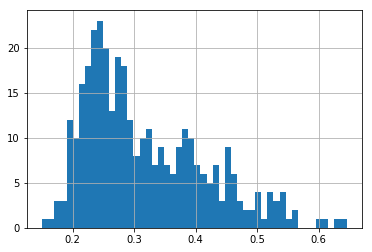

In [51]:
import matplotlib.pyplot as plt
burden[loans["type"] == "home"].hist(bins=50)
plt.show()